# [GDCV]1st_Project-ResNet_Ablation_Study
*************************************************************************
## 1. 데이터 준비
## 2. ResNet 설계
## 3. 모델 설계 및 학습
## 4. 모델 성능 비교
*************************************************************************

## 1. 데이터 준비

      CIFAR-10 데이터를 이용하여 성능을 비교분석하기 위해 불러옵니다. 255로 나누어 정규화를 진행해주고 (224, 224, 3)으로 리사이즈를 진행해 줍니다.

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

from keras.models import Model, Input
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dense, BatchNormalization
from keras.layers import Add, ZeroPadding2D, Layer
from keras.optimizers import SGD
from keras.callbacks import ReduceLROnPlateau

from keras.utils import to_categorical
from keras.datasets import mnist, cifar10
import numpy as np

In [2]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

In [4]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})
tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


In [5]:
def normalize_and_resize_img(image, label):
    #Normalizes images: `uint8` -> `float32`.#
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [6]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [7]:
ds_info.features["label"].num_classes

10

In [8]:
ds_info.features["label"].names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

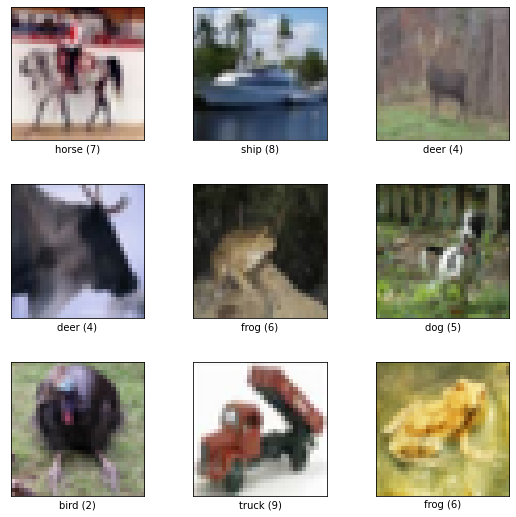

In [9]:
fig = tfds.show_examples(ds_train, ds_info)

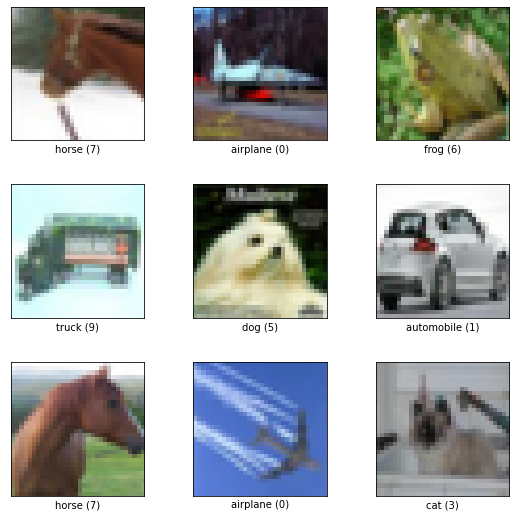

In [10]:
fig = tfds.show_examples(ds_test, ds_info)

## 2. ResNet 설계
      ResNet 구조에 따라 층을 쌓기 위한 기본 블럭을 설계해줍니다. 

In [11]:
def conv_batch(layer, channel, kernel_size, padding='same', strides=1, activation='relu', name='0'):
    x = keras.layers.Conv2D(filters=channel,
                            kernel_size=kernel_size,
                            kernel_initializer='he_normal',
                            kernel_regularizer=keras.regularizers.l2(1e-4),
                            padding=padding,
                            strides=strides,
                            name=f'conv_{name}')(layer)
    x = keras.layers.BatchNormalization(name=f'batch_{name}')(x)
    if activation:
        x = keras.layers.Activation(activation, name=f'act_{name}')(x)
    
    return x

In [12]:
def build_plain_block(input_layer, block_num=0, num_cnn=3, channel=64, is_50=True):
    x = input_layer
    
    # plain_50
    if is_50:
        for i in range(num_cnn):
            if block_num > 0 and i==0:
                x = conv_batch(x, channel, (1,1), strides=2, name=f'{block_num}_{i}1')
                x = conv_batch(x, channel, (3,3), name=f'{block_num}_{i}2')
                x = conv_batch(x, channel*4, (1,1), name=f'{block_num}_{i}3')
            else:
                x = conv_batch(x, channel, (1,1), name=f'{block_num}_{i}1')
                x = conv_batch(x, channel, (3,3), name=f'{block_num}_{i}2')
                x = conv_batch(x, channel*4, (1,1), name=f'{block_num}_{i}3')
    # plain_34
    else:
        for i in range(num_cnn):
            if block_num > 0 and i==0:
                x = conv_batch(x, channel, (3,3), strides=2, name=f'{block_num}_{i}1')
                x = conv_batch(x, channel, (3,3), name=f'{block_num}_{i}2')
            else:
                x = conv_batch(x, channel, (3,3), name=f'{block_num}_{i}1')
                x = conv_batch(x, channel, (3,3), name=f'{block_num}_{i}2')

    return x

In [13]:
def build_plain(num_cnn_list, channel_list, is_50=True, input_shape=(32,32,3), num_classes=10, name='Plain_50'):
    
    assert len(num_cnn_list) == len(channel_list)
    
    input_layer = keras.layers.Input(shape=input_shape, name='Input')
    
    # first layer
    conv1 = conv_batch(input_layer, 64, (7,7), strides=2, name='first')
    plain = keras.layers.MaxPool2D(pool_size=(2,2), strides=2, name='maxpool_first')(conv1)
    
    # plain block
    for block_num, (cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        plain = build_plain_block(plain, block_num, cnn, channel, is_50)
    
    gap = keras.layers.GlobalAveragePooling2D(name='GAP')(plain)
    
    output = keras.layers.Dense(num_classes, activation='softmax',kernel_initializer='he_normal', name='FC')(gap)
    
    model = keras.Model(inputs=input_layer, outputs=output, name=name)
    
    return model

## 3. 모델 설계 및 학습
      ResNet-34와 ResNet-50의 성능과 또 Skip Connection과의 성능 차이를 비교하기 위해 Plain모델을 설게하고 학습을 진행해줍니다.

In [14]:
plain_34 = build_plain(num_cnn_list=[3, 4, 6, 3],
                       channel_list=[64, 128, 256, 512],
                       is_50=False,
                       input_shape=(224,224,3),
                       name='Plain_34')
plain_34.summary()


Model: "Plain_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv_first (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_first (BatchNormalizat (None, 112, 112, 64)      256       
_________________________________________________________________
act_first (Activation)       (None, 112, 112, 64)      0         
_________________________________________________________________
maxpool_first (MaxPooling2D) (None, 56, 56, 64)        0         
_________________________________________________________________
conv_0_01 (Conv2D)           (None, 56, 56, 64)        36928     
_________________________________________________________________
batch_0_01 (BatchNormalizati (None, 56, 56, 64)        256

In [15]:
plain_50 = build_plain(num_cnn_list = [3, 4, 6, 3],
                       channel_list=[64, 128, 256, 512],
                       is_50=True,
                       input_shape=(224,224,3))
plain_50.summary()

Model: "Plain_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv_first (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_first (BatchNormalizat (None, 112, 112, 64)      256       
_________________________________________________________________
act_first (Activation)       (None, 112, 112, 64)      0         
_________________________________________________________________
maxpool_first (MaxPooling2D) (None, 56, 56, 64)        0         
_________________________________________________________________
conv_0_01 (Conv2D)           (None, 56, 56, 64)        4160      
_________________________________________________________________
batch_0_01 (BatchNormalizati (None, 56, 56, 64)        256

In [16]:
def build_residual_block(input_layer, block_num=0, num_cnn=3, channel=64, is_50=True):
    x = input_layer
    
    # ResNet 50
    if is_50:
        for i in range(num_cnn):
            if i==0:
                shortcut = conv_batch(x, channel*4, (1,1), strides=2, activation=None, name=f'_shortcut_{block_num}_{i}')
                x = conv_batch(x, channel, (1,1), strides=2, name=f'{block_num}_{i}1')
                x = conv_batch(x, channel, (3,3), name=f'{block_num}_{i}2')
                x = conv_batch(x, channel*4, (1,1), activation=None, name=f'{block_num}_{i}3')
            else:
                shortcut = x
                x = conv_batch(x, channel, (1,1), name=f'{block_num}_{i}1')
                x = conv_batch(x, channel, (3,3), name=f'{block_num}_{i}2')
                x = conv_batch(x, channel*4, (1,1), activation=None, name=f'{block_num}_{i}3')
            
            x = keras.layers.Add(name=f'shortcut_add_{block_num}_{i}')([x, shortcut])
            x = keras.layers.Activation('relu', name=f'shortcut_act_{block_num}_{i}')(x)
    # ResNet 34
    else:
        for i in range(num_cnn):
            if block_num > 0 and i==0:
                shortcut = conv_batch(x, channel, (1,1), strides=2, activation=None, name=f'_shortcut_{block_num}_{i}')
                x = conv_batch(x, channel, (3,3), strides=2, name=f'{block_num}_{i}1')
                x = conv_batch(x, channel, (3,3), activation=None, name=f'{block_num}_{i}2')
            else:
                shortcut = x
                x = conv_batch(x, channel, (3,3), name=f'{block_num}_{i}1')
                x = conv_batch(x, channel, (3,3), activation=None, name=f'{block_num}_{i}2')
            
            x = keras.layers.Add(name=f'shortcut_add_{block_num}_{i}')([x, shortcut])
            x = keras.layers.Activation('relu', name=f'shortcut_act_{block_num}_{i}')(x)
    

    return x

In [17]:
def build_resnet(num_cnn_list, channel_list, is_50=True, input_shape=(32,32,3), num_classes=10, name='ResNet_50'):
    
    assert len(num_cnn_list) == len(channel_list)
    
    input_layer = keras.layers.Input(shape=input_shape, name='Input')
    
    # first layer
    conv1 = conv_batch(input_layer, 64, (7,7), strides=2, name='first')
    res = keras.layers.MaxPool2D(pool_size=(2,2), strides=2, name='maxpool_first')(conv1)
    
    # Residual block
    for block_num, (cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        res = build_residual_block(res, block_num, cnn, channel, is_50)
        
    gap = keras.layers.GlobalAveragePooling2D(name='GAP')(res)
    
    output = keras.layers.Dense(num_classes, activation='softmax',kernel_initializer='he_normal', name='FC')(gap)
    
    model = keras.Model(inputs=input_layer, outputs=output, name=name)
    return model

In [18]:
resnet_34 = build_resnet(num_cnn_list = [3, 4, 6, 3],
                         channel_list=[64, 128, 256, 512],
                         is_50=False,
                         input_shape=(224,224,3),
                         name='ResNet_34')
resnet_34.summary()

Model: "ResNet_34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv_first (Conv2D)             (None, 112, 112, 64) 9472        Input[0][0]                      
__________________________________________________________________________________________________
batch_first (BatchNormalization (None, 112, 112, 64) 256         conv_first[0][0]                 
__________________________________________________________________________________________________
act_first (Activation)          (None, 112, 112, 64) 0           batch_first[0][0]                
__________________________________________________________________________________________

In [19]:
resnet_50 = build_resnet(num_cnn_list = [3, 4, 6, 3],
                         channel_list=[64, 128, 256, 512],
                         is_50=True,
                         input_shape=(224,224,3))
resnet_50.summary()

Model: "ResNet_50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv_first (Conv2D)             (None, 112, 112, 64) 9472        Input[0][0]                      
__________________________________________________________________________________________________
batch_first (BatchNormalization (None, 112, 112, 64) 256         conv_first[0][0]                 
__________________________________________________________________________________________________
act_first (Activation)          (None, 112, 112, 64) 0           batch_first[0][0]                
__________________________________________________________________________________________

In [20]:
BATCH_SIZE = 32
EPOCH = 20

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [21]:
def scheduler(epoch, lr):
    if epoch == EPOCH//2:
        lr *=0.1
        print(lr)
    elif epoch == (EPOCH//4)*3:
        lr *=0.1
        print(lr)
    return lr

In [22]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.1, monitor='val_loss', patience=1, verbose=2, min_lr=1e-6)

In [23]:
resnet_34 = build_resnet(num_cnn_list = [3, 4, 6, 3],
                         channel_list=[64, 128, 256, 512],
                         is_50=False,
                         input_shape=(224,224,3),
                         name='ResNet_34')

In [24]:
resnet_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.1, momentum=0.9, clipnorm=1.),
    metrics=['accuracy'],
)

history_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:90%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[90%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    callbacks=[lr_scheduler],
    use_multiprocessing=True,
)

Epoch 1/20
1406/1406 [==============================] - 188s 134ms/step - loss: 11.4762 - accuracy: 0.0938 - val_loss: 11.0465 - val_accuracy: 0.0899
Epoch 2/20
1406/1406 [==============================] - 202s 143ms/step - loss: 10.7849 - accuracy: 0.0951 - val_loss: 10.5587 - val_accuracy: 0.0843
Epoch 3/20
1406/1406 [==============================] - 188s 134ms/step - loss: 10.4409 - accuracy: 0.0937 - val_loss: 10.4588 - val_accuracy: 0.0815
Epoch 4/20
1406/1406 [==============================] - 188s 134ms/step - loss: 10.2612 - accuracy: 0.0944 - val_loss: 10.0377 - val_accuracy: 0.0923
Epoch 5/20
1406/1406 [==============================] - ETA: 0s - loss: 10.1336 - accuracy: 0.0953
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.
1406/1406 [==============================] - 189s 135ms/step - loss: 10.1336 - accuracy: 0.0953 - val_loss: 10.1107 - val_accuracy: 0.0958
Epoch 6/20
1406/1406 [==============================] - ETA: 0s - loss: 10.1196 - a

In [25]:
resnet_34_ACC = history_34.history['val_accuracy']

In [26]:
del resnet_34
del history_34

In [27]:
resnet_50 = build_resnet(num_cnn_list = [3, 4, 6, 3],
                         channel_list=[64, 128, 256, 512],
                         is_50=True,
                         input_shape=(224,224,3))

In [28]:
resnet_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.1, momentum=0.9, clipnorm=1.),
    metrics=['accuracy'],
)

history_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:90%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[90%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    callbacks=[lr_scheduler],
    use_multiprocessing=True,
)

Epoch 1/20
1406/1406 [==============================] - 167s 119ms/step - loss: 15.6389 - accuracy: 0.1004 - val_loss: 13.7461 - val_accuracy: 0.0993
Epoch 2/20
1406/1406 [==============================] - 138s 98ms/step - loss: 12.7525 - accuracy: 0.1007 - val_loss: 12.0361 - val_accuracy: 0.1094
Epoch 3/20
1406/1406 [==============================] - 138s 98ms/step - loss: 11.5631 - accuracy: 0.0993 - val_loss: 11.1313 - val_accuracy: 0.1065
Epoch 4/20
1406/1406 [==============================] - 139s 99ms/step - loss: 10.8901 - accuracy: 0.1004 - val_loss: 10.6656 - val_accuracy: 0.0970
Epoch 5/20
1406/1406 [==============================] - 139s 99ms/step - loss: 10.5244 - accuracy: 0.0995 - val_loss: 10.3973 - val_accuracy: 0.0897
Epoch 6/20
1406/1406 [==============================] - 139s 99ms/step - loss: 10.2889 - accuracy: 0.1017 - val_loss: 10.1827 - val_accuracy: 0.0956
Epoch 7/20
1406/1406 [==============================] - 140s 99ms/step - loss: 10.1655 - accuracy: 0.0979

In [29]:
resnet_50_ACC = history_50.history['val_accuracy']

In [30]:
del resnet_50
del history_50

In [31]:
plain_34 = build_plain(num_cnn_list=[3, 4, 6, 3],
                       channel_list=[64, 128, 256, 512],
                       is_50=False,
                       input_shape=(224,224,3),
                       name='Plain_34')

In [32]:
plain_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.1, momentum=0.9, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_34 = plain_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:90%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[90%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    callbacks=[lr_scheduler],
    use_multiprocessing=True,
)

Epoch 1/20
1406/1406 [==============================] - 179s 127ms/step - loss: 11.2158 - accuracy: 0.1045 - val_loss: 10.9089 - val_accuracy: 0.1070
Epoch 2/20
1406/1406 [==============================] - 179s 127ms/step - loss: 10.6644 - accuracy: 0.1033 - val_loss: 10.3937 - val_accuracy: 0.0981
Epoch 3/20
1406/1406 [==============================] - 179s 127ms/step - loss: 10.3900 - accuracy: 0.1019 - val_loss: 10.3681 - val_accuracy: 0.1004
Epoch 4/20
1406/1406 [==============================] - 180s 128ms/step - loss: 10.2148 - accuracy: 0.1018 - val_loss: 10.1401 - val_accuracy: 0.1010
Epoch 5/20
1406/1406 [==============================] - 179s 127ms/step - loss: 10.1276 - accuracy: 0.0980 - val_loss: 9.9905 - val_accuracy: 0.1032
Epoch 6/20
1406/1406 [==============================] - ETA: 0s - loss: 10.0955 - accuracy: 0.1031
Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.
1406/1406 [==============================] - 180s 128ms/step - loss: 10.0

In [33]:
plain_34_ACC = history_plain_34.history['val_accuracy']

In [34]:
del plain_34
del history_plain_34

In [35]:
plain_50 = build_plain(num_cnn_list = [3, 4, 6, 3],
                       channel_list=[64, 128, 256, 512],
                       is_50=True,
                       input_shape=(224,224,3))

In [36]:
plain_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.1, momentum=0.9, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_50 = plain_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:90%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[90%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    callbacks=[lr_scheduler],
    use_multiprocessing=True,
)

Epoch 1/20
1406/1406 [==============================] - 279s 198ms/step - loss: 13.6463 - accuracy: 0.1003 - val_loss: 12.5515 - val_accuracy: 0.1034
Epoch 2/20
1406/1406 [==============================] - 295s 210ms/step - loss: 12.0361 - accuracy: 0.1003 - val_loss: 11.4767 - val_accuracy: 0.1015
Epoch 3/20
1406/1406 [==============================] - 277s 197ms/step - loss: 11.1781 - accuracy: 0.0995 - val_loss: 10.8103 - val_accuracy: 0.1024
Epoch 4/20
1406/1406 [==============================] - 277s 197ms/step - loss: 10.6561 - accuracy: 0.0999 - val_loss: 10.5296 - val_accuracy: 0.1058
Epoch 5/20
1406/1406 [==============================] - 277s 197ms/step - loss: 10.3962 - accuracy: 0.0990 - val_loss: 10.3022 - val_accuracy: 0.0951
Epoch 6/20
1406/1406 [==============================] - 276s 196ms/step - loss: 10.2096 - accuracy: 0.1010 - val_loss: 10.2559 - val_accuracy: 0.1043
Epoch 7/20
1406/1406 [==============================] - 277s 197ms/step - loss: 10.1373 - accuracy: 

In [37]:
plain_50_ACC = history_plain_50.history['val_accuracy']

In [38]:
del history_plain_50
del plain_50

## 4. 모델 성능 비교
      각각의 성능을 그래프로 비교해봅니다.

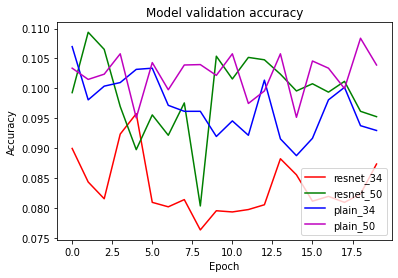

In [40]:
plt.plot(resnet_34_ACC, 'r')
plt.plot(resnet_50_ACC, 'g')
plt.plot(plain_34_ACC, 'b')
plt.plot(plain_50_ACC, 'm')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_50', 'plain_34', 'plain_50'], loc='lower right')
plt.show()


      Epoch 진행 횟수가 적어서 제대로 된 비교는 불가능 하지만 34와 50의 성능 차이는 뚜렷하게 보입니다. 

***
#  총평 및 결론

      설계하기에 난이도가 높아서 이것저것 시도하다가 제대로 된 모델을 설계하는데 실패하였다. 게다가 학습에 걸리는 시간조차 너무 오래 걸리는 프로젝트였기 때문에 다양한 시도를 하는 것이 불가능 하였다.
      
      결과도 생각하던 양상과 다르게 나와서 실패한 프로젝트라고 생각한다.